In [1]:
import os
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.insert(0, '/content/drive/My Drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms

data_dir = "/drive/My Drive/spiders_new/"
os.chdir("/content/drive/My Drive/spiders2_new_dataset/")
print(os.getcwd())



/content/drive/My Drive/spiders2_new_dataset


In [3]:
import sys
sys.argv=['']
del sys

parser = argparse.ArgumentParser()
parser.add_argument("--ngpu", type=int, default=1, help='Number of gpu.')
parser.add_argument("--d_conv_dim", type=int, default=64, help='Discriminator convolution dimension.')  # model hyperparameter
parser.add_argument("--g_conv_dim", type=int, default=64, help='Generator convolution dimension.')  # model hyperparameter
parser.add_argument("--z_size", type=int, default=100, help='Noise size - input to image generation.') # model hyperparameter
parser.add_argument("--n_epochs", type=int, default=1600, help='Number of epochs of training.')
parser.add_argument("--img_size", type=int, default=64, help='Size of each image dimension.')
parser.add_argument("--batch_size", type=int, default=1024, help="Size of the batches.")
parser.add_argument("--real_label", type=float, default=1, help="Label for real images.")
parser.add_argument("--fake_label", type=float, default=0, help="Label for fake images.")
parser.add_argument("--Loss_name: ", type=str, default="BCELoss", help="Show the name of used loss function.")
parser.add_argument("--Optim_name1: ", type=str, default="Adam", help="Show the name of the 1st used optimizator.")
parser.add_argument("--Optim_name2: ", type=str, default="RMSprop", help="Show the name of the 2nd used optimizator.")
# parser.add_argument("--Optim_name3: ", type=str, default="SGD", help="Show the name of the 3rd used optimizator.")
parser.add_argument("--lr", type=float, default=0.0002, help="Learning rate")
parser.add_argument("--beta1", type=float, default=0.5, help="First parameter to loss function(if it's necessary)")
parser.add_argument("--beta2", type=float, default=0.999, help="Second parameter to loss function(if it's necessary)")
opt = parser.parse_args()

# To easy save the parameters to the .txt file 
parserString = ""
for arg in vars(opt):
    parserString += (arg + " " + str(getattr(opt, arg)) + "\n")

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and opt.ngpu > 0) else "cpu")

In [4]:
def get_dataloader(batch_size, image_size, data_dir=os.getcwd()):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    print("hey man")
    print(data_dir)
    dataset = dset.ImageFolder(root=data_dir,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
    # Create the dataloader
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)
    return dataloader

In [5]:
# Call your function and get a dataloader
spiders_train_loader = get_dataloader(opt.batch_size, opt.img_size)

hey man
/content/drive/My Drive/spiders2_new_dataset


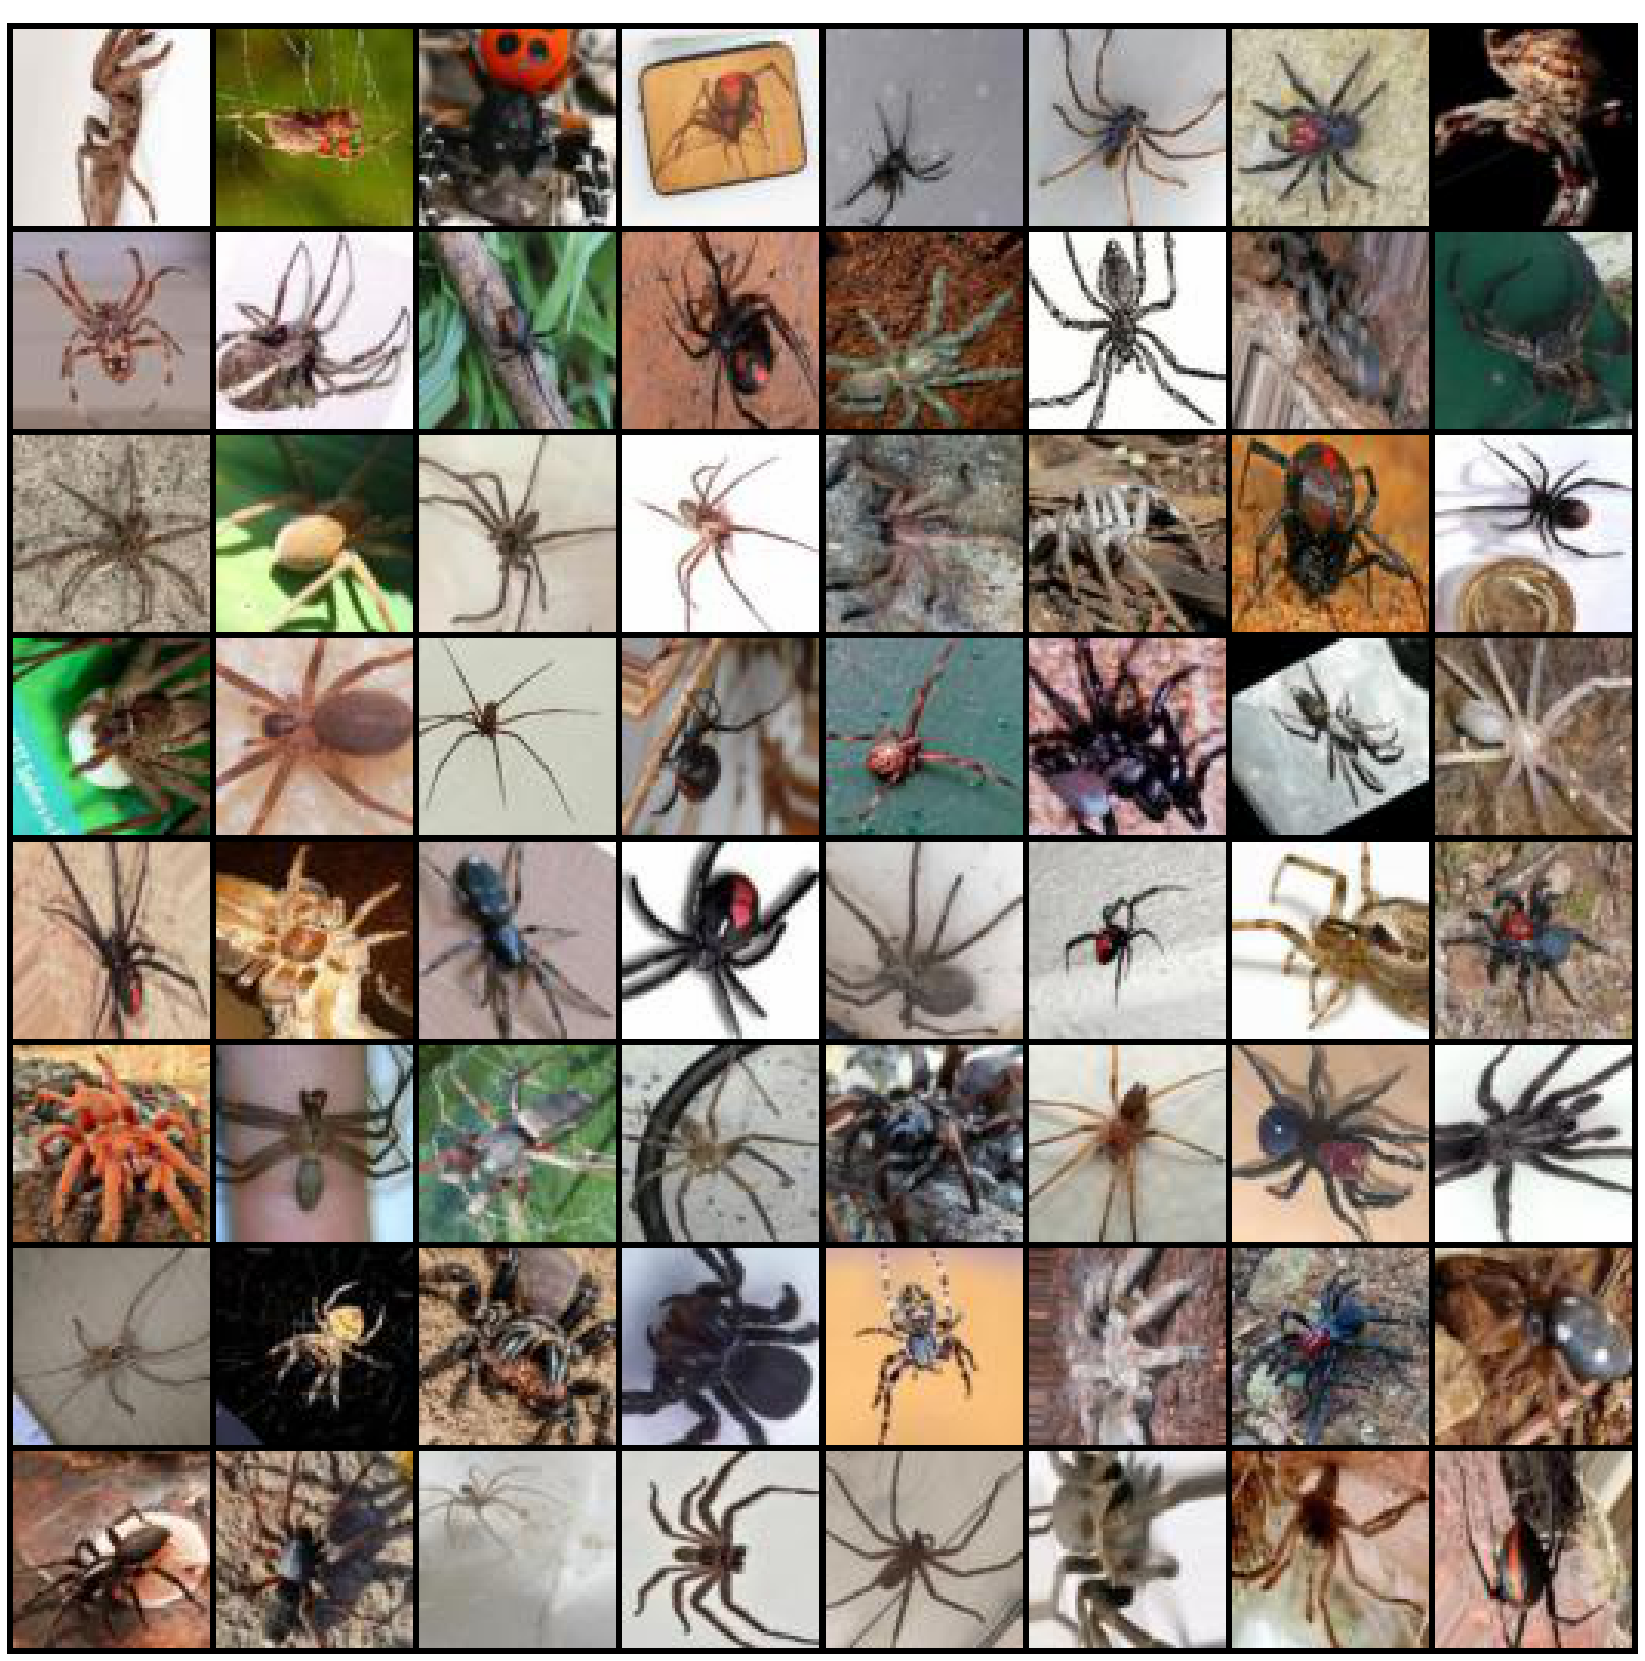

In [6]:
if (device.type == 'cuda') and (opt.ngpu > 1):
    print("\nThis is True. I'm using cuda and ngpu is bigger than 1.\n")
    print("The type of device is %s. The nb of gpu is %d. \n" %(device.type, opt.ngpu))

# Plot some training images
real_batch = next(iter(spiders_train_loader))
plt.figure(figsize=(30,30))
plt.axis("off")
plt.title("Training Images", color='white')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, ngpu=1):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.conv_dim = conv_dim
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, conv_dim, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. conv_dim x 32 x 32
            nn.Conv2d(conv_dim, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*2) x 16 x 16
            nn.Conv2d(conv_dim * 2, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*4) x 8 x 8
            nn.Conv2d(conv_dim * 4, conv_dim * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (conv_dim*8) x 4 x 4
            nn.Conv2d(conv_dim * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=64, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.conv_dim = conv_dim
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the dictionary of different optimizers with different values
optimizers = {}

# Initialize BCELoss function
criterion = nn.BCELoss()

def gan_init(number):
    # ==============================
    # CREATE THE DISCRIMINATOR
    # ==============================
    netD = Discriminator(opt.d_conv_dim, opt.ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (opt.ngpu > 1):
        netD = nn.DataParallel(netD, list(range(opt.ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netD.apply(weights_init)

    # ==============================
    # CREATE THE GENERATOR
    # ==============================
    netG = Generator(opt.z_size, opt.g_conv_dim, opt.ngpu).to(device)

    # Handle multi-gpu if desired
    if (device.type == 'cuda') and (opt.ngpu > 1):
        netG = nn.DataParallel(netG, list(range(opt.ngpu)))

    # Apply the weights_init function to randomly initialize all weights
    #  to mean=0, stdev=0.2.
    netG.apply(weights_init)

    if (number == 1):
        optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, opt.beta2))
        optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, opt.beta2))
        optimizers['Adam'] = [optimizerD, optimizerG]
    elif (number == 2):
        optimizerD = optim.RMSprop(netD.parameters(), lr=opt.lr, alpha=opt.beta1)
        optimizerG = optim.RMSprop(netG.parameters(), lr=opt.lr, alpha=opt.beta1)
        optimizers['RMSprop'] = [optimizerD, optimizerG]
    elif (number == 3):
        optimizerD = optim.SGD(netD.parameters(), lr=opt.lr)
        optimizerG = optim.SGD(netG.parameters(), lr=opt.lr)
        optimizers['SGD'] = [optimizerD, optimizerG]
    
    return netD, netG, optimizerD, optimizerG

In [11]:
## Training Loop

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Arrays where the main info will be stored
img_list_all = []
G_losses_epochs_all = []
D_losses_epochs_all = []
D_x_losses_epochs_all = []
D_G_z1_losses_epochs_all = []
D_G_z2_losses_epochs_all = []
output_train_stat_all = []

name_vers = "v1_25"

for optim_number in range (1,2):
    if (optim_number == 1):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/Adam")
    elif (optim_number == 2):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/RMSprop")
    elif (optim_number == 3):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/SGD")

    netD, netG, optimizerD, optimizerG = gan_init(optim_number)
    
    # Lists to keep track of progress
    img_list = []
    G_losses_epochs = []
    D_losses_epochs = []
    D_x_losses_epochs = []
    D_G_z1_losses_epochs = []
    D_G_z2_losses_epochs = []
    output_train_stat = []

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(opt.n_epochs):
        D_x_losses = []
        D_G_z1_losses = []
        D_G_z2_losses = []        
        G_losses = []
        D_losses = []
        # For each batch in the dataloader
        for i, data in enumerate(spiders_train_loader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), opt.real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, 100, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(opt.fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Add the gradients from the all-real and all-fake batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(opt.real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                train_stat = '[%d/%d][%d/%d]\tOpt_numb: %d\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'  % (epoch, opt.n_epochs, i, len(spiders_train_loader), optim_number, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2)
                output_train_stat.append(train_stat + "\n") 
                print(train_stat)


            D_x_losses.append(D_x)
            D_G_z1_losses.append(D_G_z1)
            D_G_z2_losses.append(D_G_z2)
            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            # It saves an image: 1) every 50th epochs; 2) the last epoch
            if ((epoch % 50 == 0) and (i == len(spiders_train_loader)-1)) or ((epoch == opt.n_epochs-1) and (i == len(spiders_train_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
                
                f_name_image = "Im_%dep_%dbs_%dis" % ((epoch+1), opt.batch_size, opt.img_size)
                # Plot the fake images from the last epoch
                fig = plt.figure(figsize=(40,40))
                #plt.subplot(1,2,2)
                plt.axis("off")
                plt.title("Fake Images", color='black')
                plt.imshow(np.transpose(img_list[-1],(1,2,0)))
                #fig.savefig('Images/v1_11/v1_11-' + f_name_image + '.png')
                fig.savefig('%s-%s.png' % (name_vers, f_name_image))
                plt.close(fig)

        D_x_losses_aver_per_epoch = round((sum(D_x_losses) / len(D_x_losses)),5)
        D_G_z1_losses_aver_per_epoch = round((sum(D_G_z1_losses) / len(D_G_z1_losses)),5)
        D_G_z2_losses_aver_per_epoch = round((sum(D_G_z2_losses) / len(D_G_z2_losses)),5)
        G_losses_aver_per_epoch = round((sum(G_losses) / len(G_losses)),5)
        D_losses_aver_per_epoch = round((sum(D_losses) / len(D_losses)),5)

        D_x_losses_epochs.append(D_x_losses_aver_per_epoch)
        D_G_z1_losses_epochs.append(D_G_z1_losses_aver_per_epoch)
        D_G_z2_losses_epochs.append(D_G_z2_losses_aver_per_epoch)
        G_losses_epochs.append(G_losses_aver_per_epoch)
        D_losses_epochs.append(D_losses_aver_per_epoch)

    img_list_all.append(img_list)
    G_losses_epochs_all.append(G_losses_epochs)
    D_losses_epochs_all.append(D_losses_epochs)
    D_x_losses_epochs_all.append(D_x_losses_epochs)
    D_G_z1_losses_epochs_all.append(D_G_z1_losses_epochs)
    D_G_z2_losses_epochs_all.append(D_G_z2_losses_epochs)
    output_train_stat_all.append(output_train_stat)

    #SAVE ALL NECESSARY INFO 
    if (optim_number == 1):
        os.chdir("/content/drive/My Drive/results/Structures/v1_25/Adam")
    elif (optim_number == 2):
        os.chdir("/content/drive/My Drive/results/Structures/v1_25/RMSprop")
    elif (optim_number == 3):
        os.chdir("/content/drive/My Drive/results/Structures/v1_25/SGD")

    torch.save(fixed_noise, '%s-fixedNoiseTensor.pt' % name_vers) #save the fixed noise to be ready to continue training on the same noise - reproduce the same images

    wrOutput = str(output_train_stat_all[-1])
    with open('%s-output.txt' % name_vers, 'w') as wrFileOutput:
        wrFileOutput.write(wrOutput)

    # SAVE THE GENERATOR INFO
    wrOptG = str(optimizerG)
    with open('%s-optimizerG.txt' % name_vers, 'w') as wrFileOptG:
        wrFileOptG.write(wrOptG)

    torch.save(netG, '%s-netG.pth' % name_vers)  # save entire net G
    torch.save(netG.state_dict(), '%s-netG_params.pth' % name_vers)  # save parameters of generator (weigths, gradients)
    torch.save(optimizerG, '%s-optimizerG.pth' % name_vers)  # save the generator optimizer
    torch.save(optimizerG.state_dict(), '%s-optimizerG_params.pth' % name_vers)  # save the parameters of the generator optimizer

    with open('%s-G_Loss_ep.txt' % name_vers, 'w') as wrGLoss:
        for valEp in G_losses_epochs_all[-1]:
            wrGLoss.write("%s\n" % valEp)

    with open('%s-DGz2_Loss_ep.txt' % name_vers, 'w') as wrDGz2Loss:
        for valEp in D_G_z2_losses_epochs_all[-1]:
            wrDGz2Loss.write("%s\n" % valEp)


    # SAVE THE DISCRIMINATOR INFO
    wrOptD = str(optimizerD)
    with open('%s-optimizerD.txt' % name_vers, 'w') as wrFileOptD:
        wrFileOptD.write(wrOptD)

    torch.save(netD, '%s-netD.pth' % name_vers)  # save entire net D
    torch.save(netD.state_dict(), '%s-netD_params.pth' % name_vers)  # save parameters of discriminator (weigths, gradients)
    torch.save(optimizerD, '%s-optimizerD.pth' % name_vers)  # save the discriminator optimizer
    torch.save(optimizerD.state_dict(), '%s-optimizerD_params.pth' % name_vers)  # save the parameters of the discriminator optimizer          

    with open('%s-D_Loss_ep.txt' % name_vers, 'w') as wrDLoss:
        for valEp in D_losses_epochs_all[-1]:
            wrDLoss.write("%s\n" % valEp)

    with open('%s-Dx_Loss_ep.txt' % name_vers, 'w') as wrDxLoss:
        for valEp in D_x_losses_epochs_all[-1]:
            wrDxLoss.write("%s\n" % valEp)

    with open('%s-DGz1_Loss_ep.txt' % name_vers, 'w') as wrDGz1Loss:
        for valEp in D_G_z1_losses_epochs_all[-1]:
            wrDGz1Loss.write("%s\n" % valEp)


Starting Training Loop...
[0/1600][0/22]	Opt_numb: 1	Loss_D: 2.0690	Loss_G: 6.0703	D(x): 0.7468	D(G(z)): 0.7616 / 0.0043
[1/1600][0/22]	Opt_numb: 1	Loss_D: 1.6460	Loss_G: 20.7126	D(x): 0.9771	D(G(z)): 0.7486 / 0.0000
[2/1600][0/22]	Opt_numb: 1	Loss_D: 2.8866	Loss_G: 23.5637	D(x): 0.9766	D(G(z)): 0.9299 / 0.0000
[3/1600][0/22]	Opt_numb: 1	Loss_D: 0.6118	Loss_G: 5.7899	D(x): 0.7846	D(G(z)): 0.1668 / 0.0148
[4/1600][0/22]	Opt_numb: 1	Loss_D: 1.0852	Loss_G: 1.8959	D(x): 0.4770	D(G(z)): 0.0988 / 0.1924
[5/1600][0/22]	Opt_numb: 1	Loss_D: 0.9723	Loss_G: 1.2097	D(x): 0.5461	D(G(z)): 0.2242 / 0.3120
[6/1600][0/22]	Opt_numb: 1	Loss_D: 0.9355	Loss_G: 2.7535	D(x): 0.8377	D(G(z)): 0.4981 / 0.0727
[7/1600][0/22]	Opt_numb: 1	Loss_D: 2.1794	Loss_G: 1.7379	D(x): 0.1871	D(G(z)): 0.0390 / 0.2208
[8/1600][0/22]	Opt_numb: 1	Loss_D: 1.9645	Loss_G: 0.8745	D(x): 0.2521	D(G(z)): 0.0433 / 0.4451
[9/1600][0/22]	Opt_numb: 1	Loss_D: 0.5022	Loss_G: 1.2866	D(x): 0.6668	D(G(z)): 0.0587 / 0.2952
[10/1600][0/22]	Opt_nu

In [12]:
# Important

os.chdir("/content/drive/My Drive/results")

torch.save(opt, 'Structures/%s/%s-parser.pth' % (name_vers, name_vers))

text_file = open("Structures/%s/%s-parser_params.txt" % (name_vers, name_vers), "w")
n = text_file.write(parserString)
text_file.close()

wrGStruct = str(netG)
with open('Structures/%s/%s-netG_struct.txt' % (name_vers, name_vers), 'w') as wrFileGStruct:
    wrFileGStruct.write(wrGStruct)

wrDStruct = str(netD)
with open('Structures/%s/%s-netD_struct.txt' % (name_vers, name_vers), 'w') as wrFileDStruct:
    wrFileDStruct.write(wrDStruct)


In [13]:
# SAVE THE LOSSES

os.chdir("/content/drive/My Drive/results")

for optim_number in range (1,2):
    if (optim_number == 1):
        name = "Ad"
        g_label="G_Adam"
        d_label="D_Adam"
    elif (optim_number == 2):
        name = "RMS"
        g_label="G_RMSprop"
        d_label="D_RMSprop"
    elif (optim_number == 3):
        name = "SGD"
        g_label="G_SGD"
        d_label="D_SGD"

    f_name_loss = "Loss_%s_%dep_%dbs_%dis" % (name, opt.n_epochs, opt.batch_size, opt.img_size)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    plt.grid(color='black')
    plt.title("Generator and Discriminator Loss During Training", color='black', size = 20)
    plt.plot(G_losses_epochs_all[-1],label=g_label)
    plt.plot(D_losses_epochs_all[-1],label=d_label)
    plt.xlabel("Epochs", color='black', size = 13)
    plt.ylabel("Loss", color='black', size=13)
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=100)
    locY = plticker.MultipleLocator(base=5)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(locY)
    plt.legend()
    fig.savefig('Losses/%s/%s-%s.png' % (name_vers, name_vers, f_name_loss))

    plt.ylim(-50,50)
    fig.savefig('Losses/%s/%s-%s_AD2.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(0,50)
    fig.savefig('Losses/%s/%s-%s_AD3.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(0,100)
    fig.savefig('Losses/%s/%s-%s_AD4.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(0,20)
    fig.savefig('Losses/%s/%s-%s_AD5.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(-100,100)
    fig.savefig('Losses/%s/%s-%s_AD6.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(-10,10)
    fig.savefig('Losses/%s/%s-%s_AD7.png' % (name_vers, name_vers, f_name_loss))
    plt.ylim(-20,20)
    fig.savefig('Losses/%s/%s-%s_AD8.png' % (name_vers, name_vers, f_name_loss))
    plt.close(fig)




Animation size has reached 21785511 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


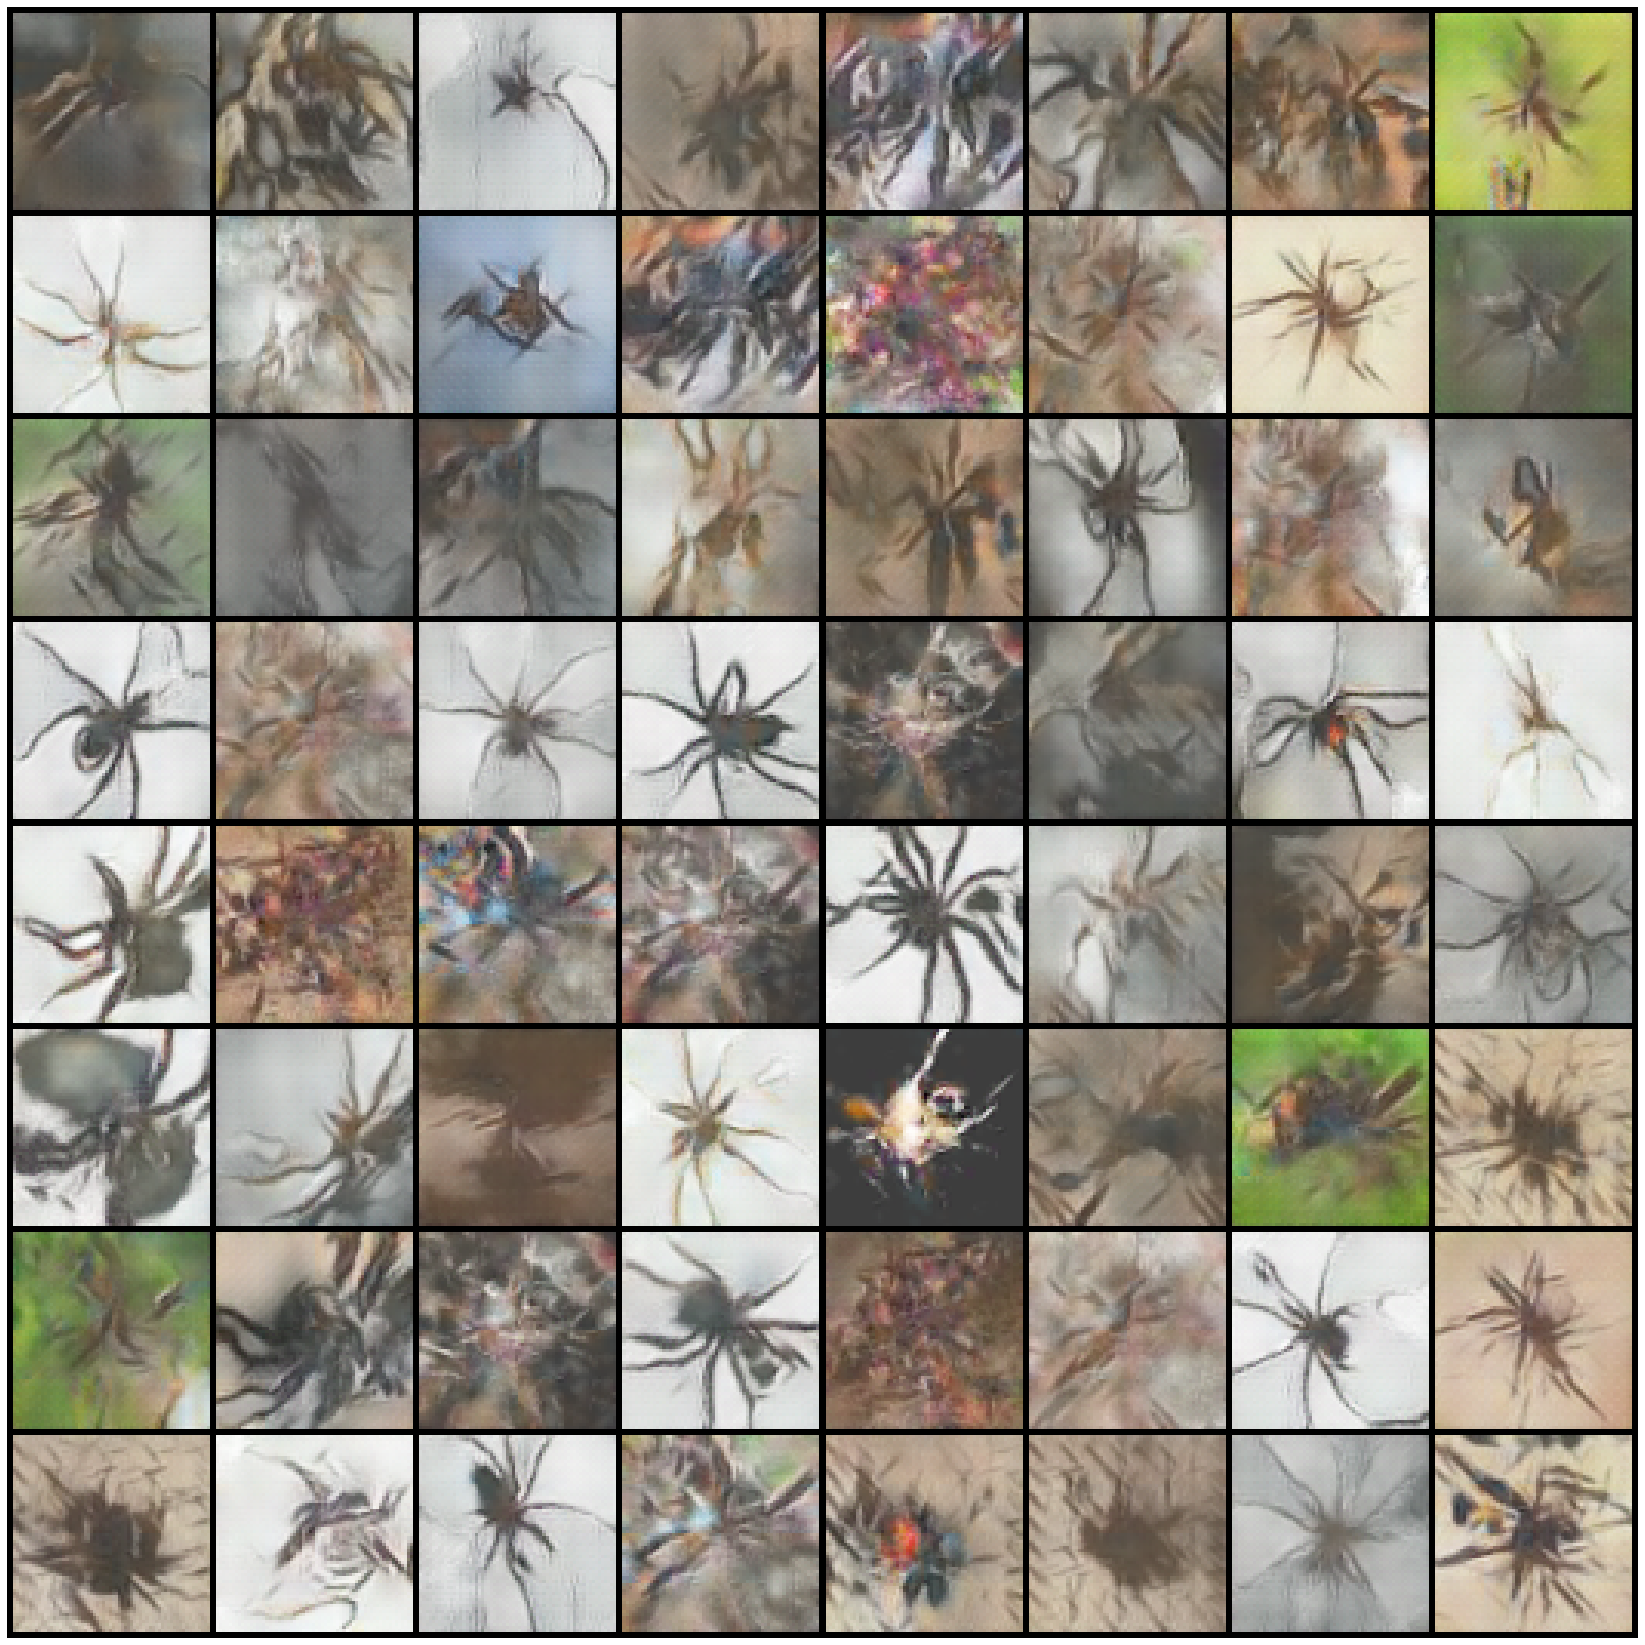

In [14]:
for optim_number in range (1,2):
    if (optim_number == 1):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/Adam")
    elif (optim_number == 2):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/RMSprop")
    elif (optim_number == 3):
        os.chdir("/content/drive/My Drive/results/Images/v1_25/SGD")

    fig = plt.figure(figsize=(30,30))
    plt.axis("off")
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list_all[-1]]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

    ani.save('%s-Animation_training.mp4' % name_vers)

    HTML(ani.to_jshtml())

In [15]:


#optim_keys = list(optimizers.keys())


#====================================================================================================================
#                             1 Optimizer: Adam.
#====================================================================================================================
# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, opt.beta2))
# optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, opt.beta2))

#====================================================================================================================
#                             2 Optimizer: ASGD.
#====================================================================================================================
# # Setup ASGD optimizers for both G and D
# optimizerD = optim.ASGD(netD.parameters(), lr=lr)
# optimizerG = optim.ASGD(netG.parameters(), lr=lr)

#====================================================================================================================
#                             3 Optimizer: RMSprop.
#====================================================================================================================
# # Setup RMSprop optimizers for both G and D
# optimizerD = optim.RMSprop(netD.parameters(), lr=lr, alpha=beta1)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr, alpha=beta1)

#====================================================================================================================
#                             4 Optimizer: SGD.
#====================================================================================================================
# # Setup SGD optimizers for both G and D
# optimizerD = optim.SGD(netD.parameters(), lr=lr)
# optimizerG = optim.SGD(netG.parameters(), lr=lr)

#====================================================================================================================
#                             5 Optimizer: Rprop.
#====================================================================================================================
# # Setup Rprop optimizers for both G and D
# optimizerD = optim.Rprop(netD.parameters(), lr=lr, etas=(beta1, 1.2))
# optimizerG = optim.Rprop(netG.parameters(), lr=lr, etas=(beta1, 1.2))